In [91]:
import numpy as np
import matplotlib.pyplot as plt

# The prysm stuff
from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.propagation import Wavefront, focus_fixed_sampling
from prysm.geometry import circle,spider
from prysm.segmented import CompositeHexagonalAperture
from prysm import thinlens
from prysm.polynomials import (
    noll_to_nm,
    zernike_nm,
    zernike_nm_sequence,
    hopkins,
    sum_of_2d_modes
)

np.random.seed(20240820)

In [92]:
# USER INPUT HERE
# IC = Instrument Configuration
IC = {
    'image_dx' : 4.87, # um
    'pupil_diameter' : 10950, # mm
    'focal_length' : 338492, # mm
    'wavelength' : 0.94, # um
}
SEGMENTED_PUPIL = False

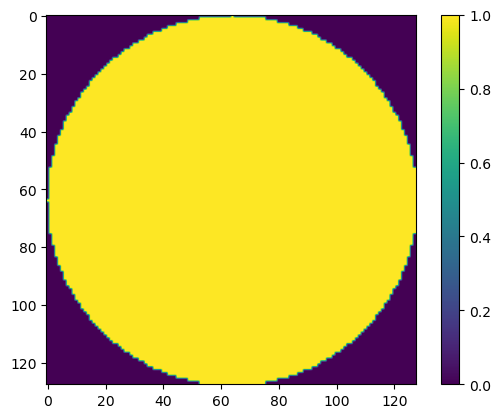

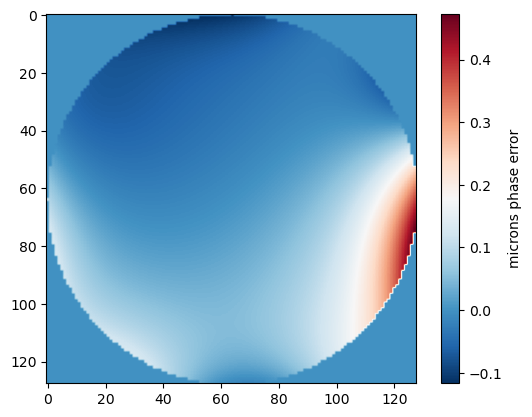

In [93]:
# optical system parameters
epd = IC['pupil_diameter'] # mm
efl = IC['focal_length'] # mm, Keck is F/13 I think
fno = efl / epd
wvl = IC['wavelength'] # um

# build the coordinate grids
x, y = make_xy_grid(128, diameter=epd)
r, t = cart_to_polar(x, y)
dx_p = x[0,1] - x[0,0]

if SEGMENTED_PUPIL:
    # make a keck-like pupil
    cha = CompositeHexagonalAperture(x, y, 3, 1.32e3, 0.007e3, exclude=(0,))

    # set up spiders
    m1 = spider(1, .1e3, x, y, rotation=-120)
    m2 = spider(1, .1e3, x, y, rotation=-60)
    m3 = spider(1, .1e3, x, y, rotation=90)
    spider_ = m1&m2&m3
    A = cha.amp & spider_

else:
    A = circle(epd / 2, r)

plt.figure()
plt.imshow(A)
plt.colorbar()
plt.show()

# construct a polynomial basis to generate wavefront error
r_z = r / (epd / 2) # normalized radius
nms = [noll_to_nm(j) for j in range(2, 37)]
coefs = np.random.random(len(nms))
basis = list(zernike_nm_sequence(nms, r, t, norm=True))
basis_norm = [b / np.max(np.abs(b)) for b in basis]
phs = sum_of_2d_modes(basis_norm, coefs) * 1/10
amp = A

plt.figure()
plt.imshow(phs * amp, cmap='RdBu_r')
plt.colorbar(label='microns phase error')
plt.show()

# Propagate to focus
# NOTE: Phase should be in nm, wvl should be in microns, dx_p should be in mm
# NOTE: WAVEFRONT AND FOCUS_FIXED_SAMPLING HAVE DIFFERENT NORMALIZATIONS AND THROW OFF THE ALGORITHM
k = 2 * np.pi / wvl # enforces phs in microns
wf = amp * np.exp(1j * k * phs)

def prop_to_focus(wavefunction, defocus_waves=0):

    # configure the defocus polynomial
    focus_polynomial = hopkins(0, 2, 0, r_z, t, 0) * defocus_waves
    defocus_aberration = amp * np.exp(-1j * 2 * np.pi * focus_polynomial)


    psf = focus_fixed_sampling(wavefunction=wavefunction * defocus_aberration,
                            input_dx=dx_p,
                            prop_dist=efl,
                            wavelength=wvl,
                            output_dx=IC['image_dx'],
                            output_samples=128)
    psf0 = np.abs(psf)**2
    return psf0

psf0 = prop_to_focus(wf, defocus_waves=0)
psf1 = prop_to_focus(wf, defocus_waves=1)
psf2 = prop_to_focus(wf, defocus_waves=2)
psf3 = prop_to_focus(wf, defocus_waves=3)

In [32]:
help(thinlens.defocus_to_image_displacement)

Help on function defocus_to_image_displacement in module prysm.thinlens:

defocus_to_image_displacement(W020, fno, wavelength=None)
    Compute image displacment from wavefront defocus expressed in waves 0-P to.
    
    Parameters
    ----------
    W020 : float or numpy.ndarray
        wavefront defocus, units of waves if wavelength != None, else units of length
    fno : float
        f/# of the lens or system
    wavelength : float, optional
        wavelength of light, if None W020 takes units of length
    
    Returns
    -------
    float
        image displacement.  Motion of image in um caused by defocus OPD



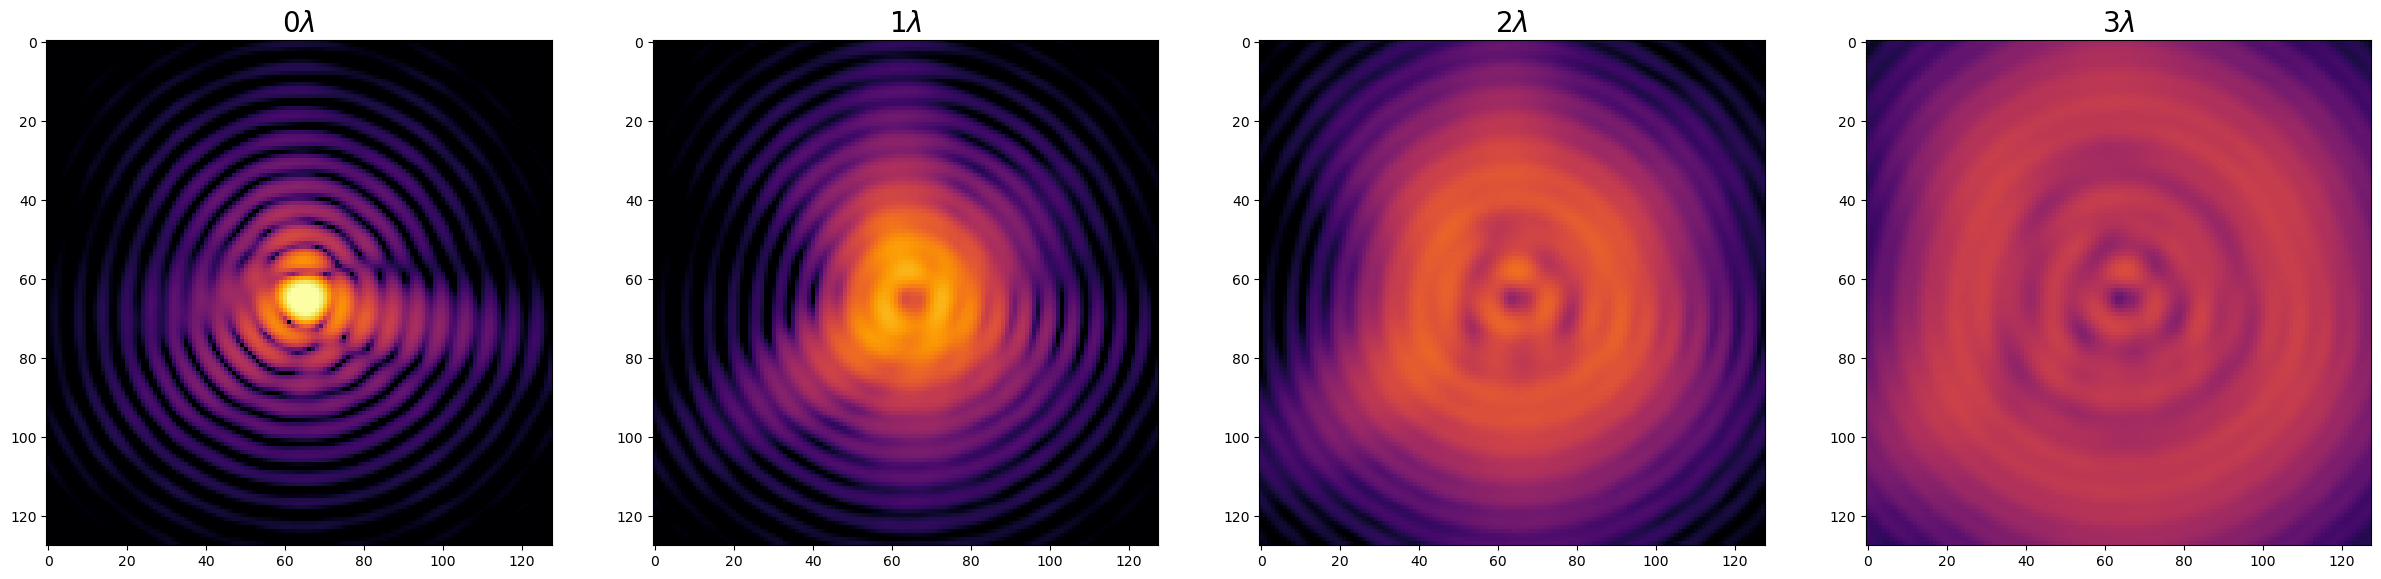

In [94]:
psflist = [psf0, psf1, psf2, psf3]
titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(psflist,axs,titles):
    ax.set_title(title,fontsize=20)
    # _psf /= np.max(_psf)
    ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-2)
plt.show()

In [34]:
import poi
# adpr = poi.ADPhaseRetrieval(amp, psf0, IC, basis_norm, defocus=0)
adpr = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, psflist[0], IC['image_dx'])

In [35]:
adpr.fwd(np.zeros(len(coefs)))

310901.0612829415

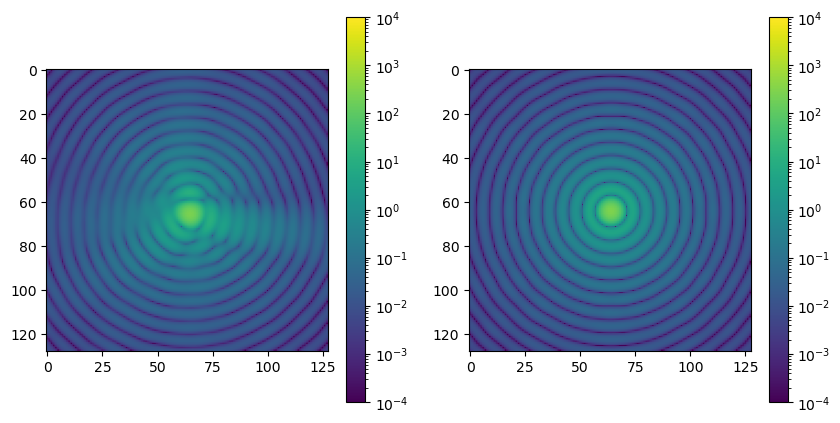

In [36]:
from matplotlib.colors import LogNorm
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.imshow(adpr.D, norm=LogNorm(vmin=1e-4,vmax=1e4))
plt.colorbar()
plt.subplot(122)
plt.imshow(adpr.I, norm=LogNorm(vmin=1e-4,vmax=1e4))
plt.colorbar()
plt.show()


In [37]:
from scipy.optimize import minimize
results = minimize(adpr.fg, x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-20, 'gtol': 1e-20, 'disp': 1})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10901D+05    |proj g|=  3.78933D+06

At iterate    1    f=  6.07535D+04    |proj g|=  1.62646D+06

At iterate    2    f=  2.20062D+04    |proj g|=  8.40614D+04

At iterate    3    f=  2.17989D+04    |proj g|=  4.73454D+04

At iterate    4    f=  2.16925D+04    |proj g|=  4.81640D+04

At iterate    5    f=  2.06915D+04    |proj g|=  1.61068D+05

At iterate    6    f=  1.78965D+04    |proj g|=  4.38646D+05

At iterate    7    f=  1.58973D+04    |proj g|=  5.94075D+05

At iterate    8    f=  1.29902D+04    |proj g|=  5.71839D+05

At iterate    9    f=  8.39293D+03    |proj g|=  4.13996D+05

At iterate   10    f=  5.82770D+03    |proj g|=  3.74973D+04

At iterate   11    f=  5.80335D+03    |proj g|=  7.93841D+03

At iterate   12    f=  5.79703D+03    |proj g|=  7.87897D+03

At iterate   13    f=  5.7

 This problem is unconstrained.



At iterate   32    f=  2.72785D+02    |proj g|=  1.72555D+04

At iterate   33    f=  2.38332D+02    |proj g|=  2.00508D+04

At iterate   34    f=  2.12753D+02    |proj g|=  6.56738D+03

At iterate   35    f=  1.92450D+02    |proj g|=  1.24110D+04

At iterate   36    f=  1.61165D+02    |proj g|=  1.27982D+04

At iterate   37    f=  1.26362D+02    |proj g|=  1.36561D+04

At iterate   38    f=  1.14684D+02    |proj g|=  1.08680D+04

At iterate   39    f=  1.04535D+02    |proj g|=  5.02757D+03

At iterate   40    f=  1.02115D+02    |proj g|=  5.67628D+03

At iterate   41    f=  9.84132D+01    |proj g|=  6.37798D+03

At iterate   42    f=  9.44327D+01    |proj g|=  4.07645D+03

At iterate   43    f=  8.78834D+01    |proj g|=  3.38669D+03

At iterate   44    f=  8.65896D+01    |proj g|=  2.78195D+04

At iterate   45    f=  7.21314D+01    |proj g|=  1.00791D+04

At iterate   46    f=  6.20528D+01    |proj g|=  3.49449D+03

At iterate   47    f=  5.50985D+01    |proj g|=  5.63506D+03

At iter

In [38]:
print(results)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 1.271530637961068e-05
        x: [ 6.741e-02  8.777e-02 ...  9.113e-02  5.639e-02]
      nit: 13530
      jac: [-1.626e-02 -1.081e-02 ... -8.585e-03  1.036e-02]
     nfev: 15001
     njev: 15001
 hess_inv: <35x35 LbfgsInvHessProduct with dtype=float64>


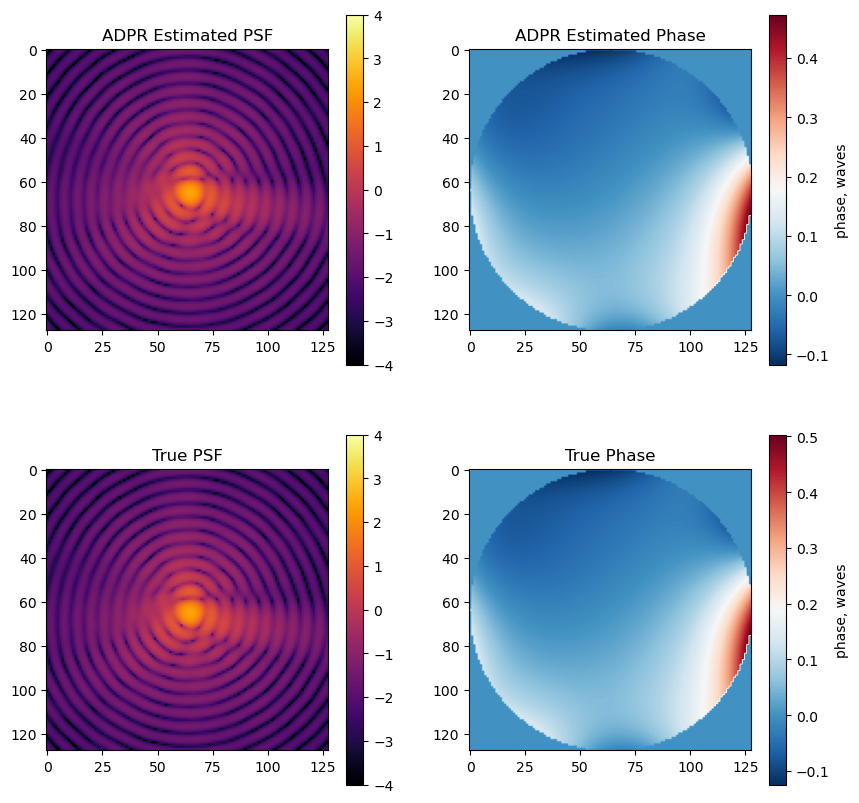

In [39]:
test_vector = np.zeros_like(coefs)
test_vector[2] = 2
k = 2 * np.pi / wvl
E = adpr.fwd(results.x)

plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(adpr.I), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(adpr.W * amp / k, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(adpr.D), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phs * amp / (wvl), cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

In [40]:
adpr1 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, psflist[1], IC['image_dx'], defocus_waves=1)

In [41]:
results = minimize(adpr1.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-17, 'gtol': 1e-17, 'disp': 1})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49023D+04    |proj g|=  4.58359D+04

At iterate    1    f=  5.77677D+03    |proj g|=  2.92883D+04

At iterate    2    f=  1.92522D+03    |proj g|=  1.88119D+04

At iterate    3    f=  7.78722D+02    |proj g|=  1.19443D+04

At iterate    4    f=  5.02035D+02    |proj g|=  4.31631D+03

At iterate    5    f=  3.43377D+02    |proj g|=  2.86337D+03

At iterate    6    f=  2.28125D+02    |proj g|=  3.25794D+03

At iterate    7    f=  1.24543D+02    |proj g|=  5.53684D+03

At iterate    8    f=  7.99382D+01    |proj g|=  9.85649D+02

At iterate    9    f=  6.81494D+01    |proj g|=  9.87884D+02

At iterate   10    f=  4.68317D+01    |proj g|=  1.57032D+03

At iterate   11    f=  4.24198D+01    |proj g|=  9.29877D+02

At iterate   12    f=  3.88373D+01    |proj g|=  6.18365D+02

At iterate   13    f=  3.3

 This problem is unconstrained.



At iterate   14    f=  3.11614D+01    |proj g|=  5.57298D+02

At iterate   15    f=  2.84079D+01    |proj g|=  3.79307D+02

At iterate   16    f=  2.45063D+01    |proj g|=  3.23148D+02

At iterate   17    f=  2.06095D+01    |proj g|=  8.41702D+02

At iterate   18    f=  1.71211D+01    |proj g|=  4.40453D+02

At iterate   19    f=  1.53170D+01    |proj g|=  3.64405D+02

At iterate   20    f=  1.30076D+01    |proj g|=  4.23885D+02

At iterate   21    f=  9.89445D+00    |proj g|=  4.93897D+02

At iterate   22    f=  8.26919D+00    |proj g|=  9.65659D+02

At iterate   23    f=  6.94327D+00    |proj g|=  3.07829D+02

At iterate   24    f=  6.45083D+00    |proj g|=  2.24448D+02

At iterate   25    f=  5.62228D+00    |proj g|=  1.81425D+02

At iterate   26    f=  4.92207D+00    |proj g|=  2.07220D+02

At iterate   27    f=  4.30960D+00    |proj g|=  3.42479D+02

At iterate   28    f=  3.61596D+00    |proj g|=  1.48011D+02

At iterate   29    f=  2.94062D+00    |proj g|=  1.97695D+02

At iter

/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_36395/3138656705.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(phase_est / amp, cmap='RdBu_r')
/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_36395/3138656705.py:28: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(phase_truth / amp, cmap='RdBu_r')


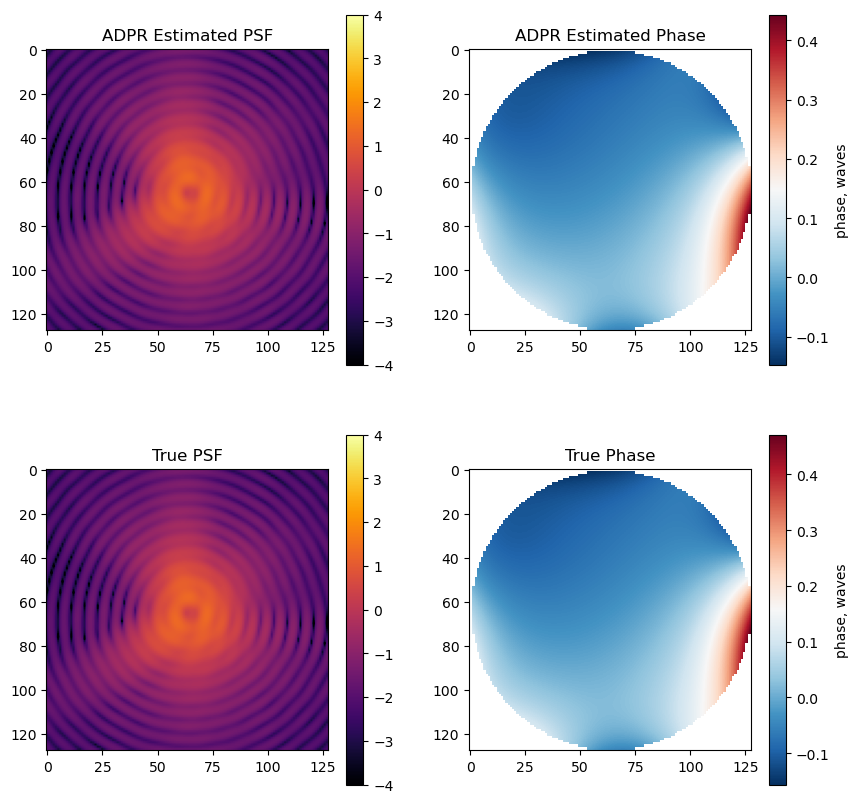

In [42]:
test_vector = np.zeros_like(coefs)
test_vector[2] = 0
k = 2 * np.pi / wvl
E = adpr.fwd(results.x)

phase_est = adpr1.phs
phase_est -= np.mean(phase_est[amp==1])

phase_truth = phs / (wvl)
phase_truth -= np.mean(phase_truth[amp==1])


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(adpr1.I), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est / amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(adpr1.D), cmap='inferno', vmax=4, vmin=-4)
plt.colorbar()
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth / amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

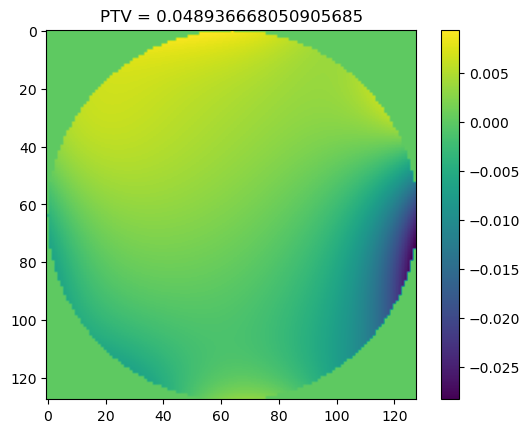

In [43]:
phase_diff = phase_est - phase_truth
plt.figure()
plt.title(f'PTV = {phase_diff.max() - phase_diff.min()}')
plt.imshow(phase_diff * amp)
plt.colorbar()
# 0.65, 2, positive in middle
# , 1

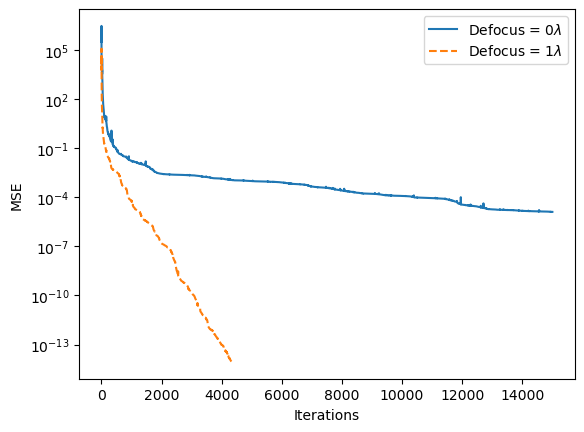

In [44]:
plt.plot()
plt.plot(adpr.cost, label='Defocus = '+r'$0\lambda$')
plt.plot(adpr1.cost, label='Defocus = '+r'$1\lambda$', linestyle='dashed')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

# And now we try focus diversity

In [45]:
# configure the individual optimizers
adpr0 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, psflist[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, psflist[1], IC['image_dx'], defocus_waves=1)

# set up the net optimizer
optlist = [adpr0, adpr1]
fdpr = poi.ParallelADPhaseRetrieval(optlist)

In [46]:
results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'ftol': 1e-17, 'gtol': 1e-17, 'disp': 1})

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25803D+05    |proj g|=  3.83516D+06

At iterate    1    f=  7.07739D+04    |proj g|=  1.63866D+06

At iterate    2    f=  3.15337D+04    |proj g|=  8.49481D+04

At iterate    3    f=  3.09704D+04    |proj g|=  8.55898D+04

At iterate    4    f=  2.86331D+04    |proj g|=  1.92677D+05

At iterate    5    f=  2.22680D+04    |proj g|=  6.48115D+05

At iterate    6    f=  1.99376D+04    |proj g|=  7.84367D+05

At iterate    7    f=  1.33276D+04    |proj g|=  6.32482D+05

At iterate    8    f=  2.54327D+03    |proj g|=  1.32804D+05

At iterate    9    f=  2.25682D+03    |proj g|=  4.33755D+04

At iterate   10    f=  2.16331D+03    |proj g|=  2.92395D+04

At iterate   11    f=  1.95486D+03    |proj g|=  2.80441D+04

At iterate   12    f=  1.42115D+03    |proj g|=  1.17416D+05

At iterate   13    f=  9.4

In [47]:
print(results)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 5.737041280268038e-13
        x: [ 6.741e-02  8.772e-02 ...  9.113e-02  5.640e-02]
      nit: 13547
      jac: [ 6.598e-05 -4.374e-05 ...  3.390e-06 -1.630e-06]
     nfev: 15001
     njev: 15001
 hess_inv: <35x35 LbfgsInvHessProduct with dtype=float64>


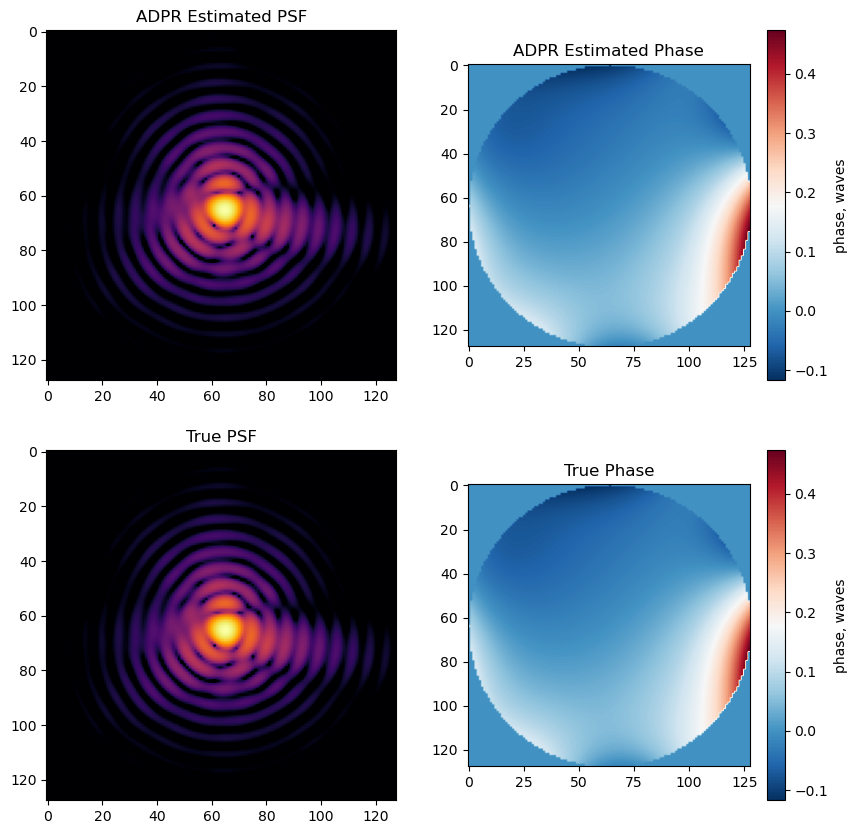

In [48]:
k = 2 * np.pi / wvl

psf_est = fdpr.optlist[0].I
psf_est /= psf_est.max()
psf_truth = fdpr.optlist[0].D
psf_truth /= psf_truth.max()

phase_est = sum_of_2d_modes(basis_norm, results.x)
phase_truth = phs


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(psf_est), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(psf_truth), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()

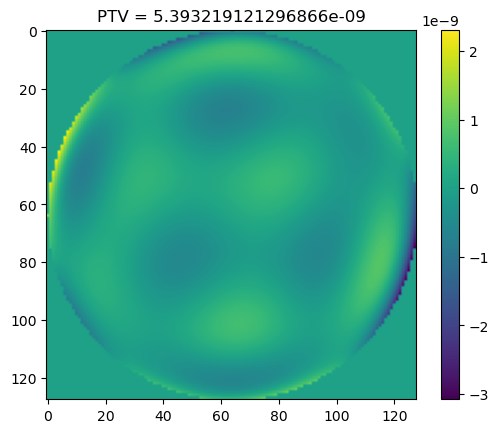

In [49]:
phase_diff = phase_est - phase_truth
phase_diff -= np.mean(phase_diff[amp==1])
plt.figure()
plt.title(f'PTV = {phase_diff[amp==1].max() - phase_diff[amp==1].min()}')
plt.imshow(phase_diff * amp)
plt.colorbar()

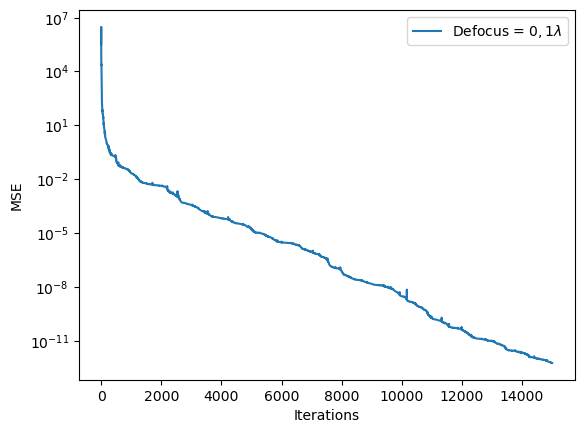

In [50]:
plt.plot()
plt.plot(fdpr.cost, label='Defocus = '+r'$0, 1\lambda$')
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.yscale('log')
plt.show()

# Try with poisson noisy data

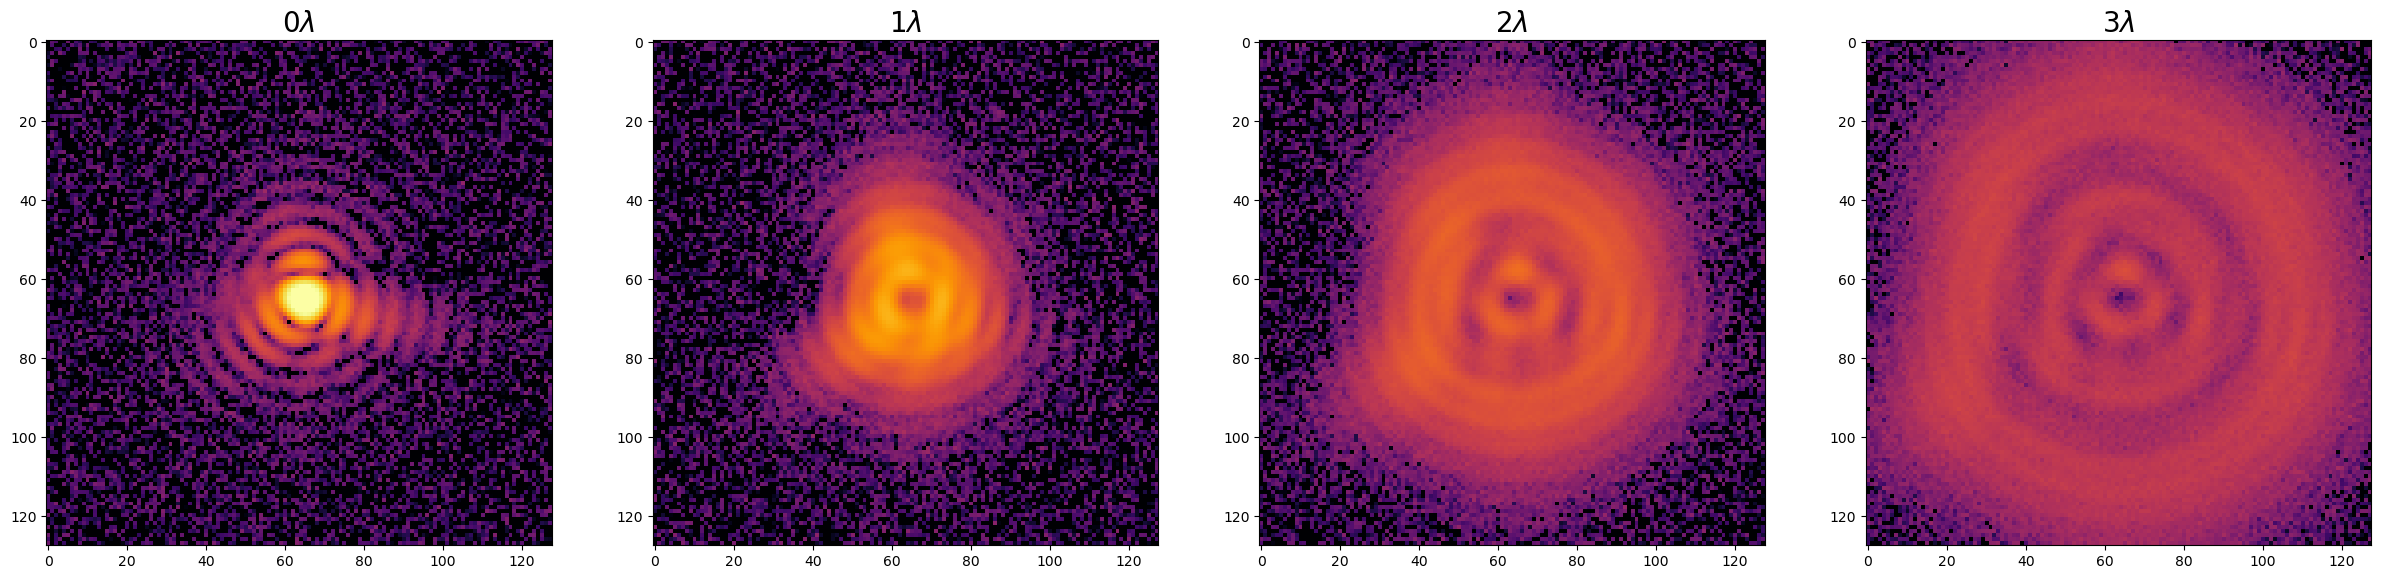

In [104]:
noisy_psfs = [np.random.normal(p, scale=1e-1) for p in psflist]
# mask them
for i, p in enumerate(noisy_psfs):
    p[p <= 1e-5] = 1e-20
    noisy_psfs[i] = p

for i, pnom in enumerate(psflist):
    energy_nom = np.sum(pnom)
    energy_noisy = np.sum(noisy_psfs[i])
    noisy_psfs[i] *=  (energy_nom / energy_noisy)

titles = [f'{i}'+r'$\lambda$' for i in range(0,4)]
fig,axs = plt.subplots(ncols=len(psflist),figsize=[30,10])
for _psf,ax,title in zip(noisy_psfs,axs,titles):
    ax.set_title(title,fontsize=20)
    ax.imshow(np.log10((_psf)),cmap='inferno',vmax=2,vmin=-2)
plt.show()

In [105]:
# configure the individual optimizers
adpr0 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, noisy_psfs[0], IC['image_dx'], defocus_waves=0)
adpr1 = poi.ADPhaseRetireval(amp, dx_p, efl, wvl, basis_norm, noisy_psfs[1], IC['image_dx'], defocus_waves=1)

# set up the net optimizer
optlist = [adpr0, adpr1]
fdpr = poi.ParallelADPhaseRetrieval(optlist)

In [106]:
results = minimize(fdpr.fg,
                   x0=np.zeros(len(coefs)),
                   jac=True, method='L-BFGS-B',
                   options={'maxls': 20, 'disp': 1})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25504D+05    |proj g|=  3.70858D+06

At iterate    1    f=  7.88792D+04    |proj g|=  1.58516D+06

At iterate    2    f=  4.09177D+04    |proj g|=  8.32957D+04

At iterate    3    f=  4.03385D+04    |proj g|=  8.44258D+04

At iterate    4    f=  3.71903D+04    |proj g|=  2.41639D+05

At iterate    5    f=  3.03765D+04    |proj g|=  8.69680D+05

At iterate    6    f=  1.27854D+04    |proj g|=  4.96361D+05

At iterate    7    f=  4.61770D+03    |proj g|=  9.29205D+04

At iterate    8    f=  4.42166D+03    |proj g|=  5.57828D+04

At iterate    9    f=  4.13213D+03    |proj g|=  4.02719D+04

At iterate   10    f=  3.58956D+03    |proj g|=  6.14800D+04


 This problem is unconstrained.



At iterate   11    f=  2.78254D+03    |proj g|=  9.24244D+04

At iterate   12    f=  2.20747D+03    |proj g|=  8.31855D+04

At iterate   13    f=  2.08969D+03    |proj g|=  2.64228D+04

At iterate   14    f=  2.04356D+03    |proj g|=  1.01272D+04

At iterate   15    f=  2.00676D+03    |proj g|=  1.92483D+04

At iterate   16    f=  1.92472D+03    |proj g|=  4.30543D+04

At iterate   17    f=  1.77967D+03    |proj g|=  6.01394D+04

At iterate   18    f=  1.62137D+03    |proj g|=  4.44065D+04

At iterate   19    f=  1.53302D+03    |proj g|=  1.29222D+04

At iterate   20    f=  1.47957D+03    |proj g|=  2.03838D+04

At iterate   21    f=  1.44471D+03    |proj g|=  3.73670D+04

At iterate   22    f=  1.37322D+03    |proj g|=  5.42305D+04

At iterate   23    f=  1.26929D+03    |proj g|=  5.59533D+04

At iterate   24    f=  1.24195D+03    |proj g|=  5.78054D+04

At iterate   25    f=  1.14294D+03    |proj g|=  3.81513D+04

At iterate   26    f=  1.12019D+03    |proj g|=  1.81155D+04

At iter

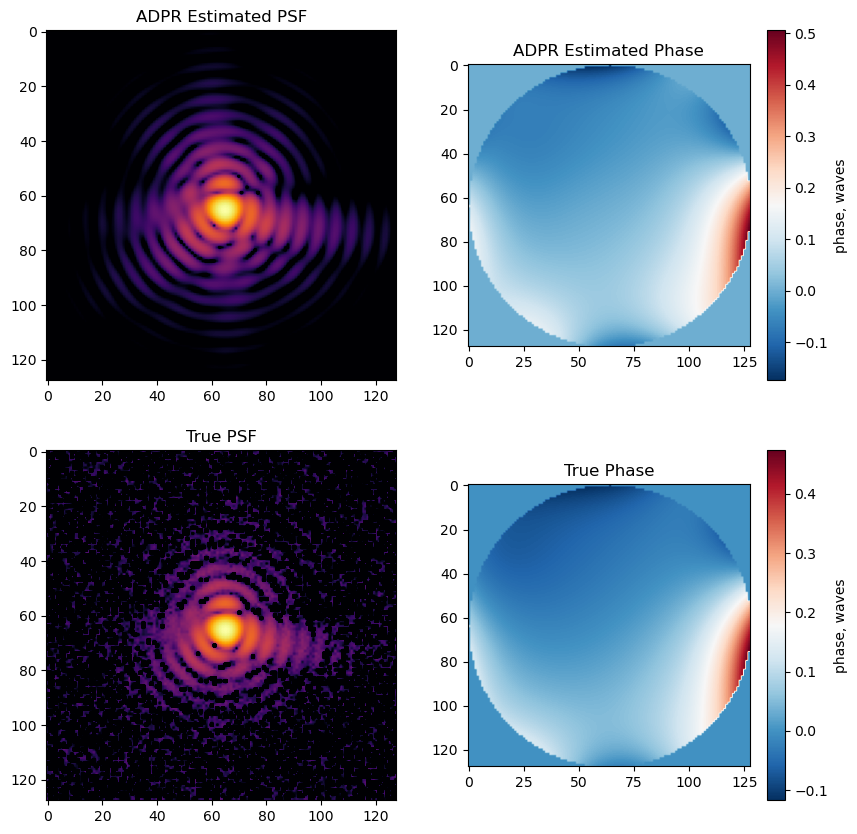

In [107]:
k = 2 * np.pi / wvl

psf_est = fdpr.optlist[0].I
psf_est /= psf_est.max()
psf_truth = fdpr.optlist[0].D
psf_truth /= psf_truth.max()

phase_est = sum_of_2d_modes(basis_norm, results.x)
phase_truth = phs


plt.figure(figsize=[10,10])
plt.subplot(221)
plt.title('ADPR Estimated PSF')
plt.imshow(np.log10(psf_est), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(222)
plt.title('ADPR Estimated Phase')
plt.imshow(phase_est * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.subplot(223)
plt.title('True PSF')
plt.imshow(np.log10(psf_truth), cmap='inferno', vmax=0, vmin=-4)
plt.subplot(224)
plt.title('True Phase')
plt.imshow(phase_truth * amp, cmap='RdBu_r')
plt.colorbar(label='phase, waves')
plt.show()